In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skrub import GapEncoder

In [2]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

train.shape, test.shape

((17499636, 19), (4393179, 19))

In [3]:
train.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [4]:
train.columns

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration'],
      dtype='object')

In [5]:
train.dtypes

status                    int64
gender                   object
firstName                object
level                    object
lastName                 object
userId                   object
ts                        int64
auth                     object
page                     object
sessionId                 int64
location                 object
itemInSession             int64
userAgent                object
method                   object
length                  float64
song                     object
artist                   object
time             datetime64[us]
registration     datetime64[us]
dtype: object

In [6]:
train['time'].min(), train['time'].max()

(Timestamp('2018-10-01 00:00:01'), Timestamp('2018-11-20 00:00:00'))

**Conceptual Outline**:

Our key columns are userId, time and page. We want features that describe how the user behaved before the prediction point, not after, to prevent leakage from the future. 

Thus, we define a prediction time for each user. We want to predict churn in the next 10 days, thus we need a moment in time $T_\text{pred}$ at which we pretend to make the prediction. 

Then, there are two options. 1) The user churns (has a "cancellation confirmation" event), then we set $T_\text{pred}$ 10 days before $T_\text{churn}$. 2) The user does not churn in the training set, then we set the prediction time 10 days before the last observed event. $T_\text{pred} = T_\text{pred} - 10 \text{days}$.

Everythin we compute as features must only ever use events with time before $T_\text{pred}$, otherwise we have data leakage.

**Feature 1**:

I propose "recency of activity" , i.e. days since last event, as a feature predicting churn. Users who have not done anything for a long time are more likely to churn. For each user, we look at all events with timestamp before $T_\text{pred}$ and find the last event before $T_\text{pred}$.

A possible interpretation would be: Small value: The user was active right before the prediction point and has lower churn risk. Large value: The user was inactive for many days, higher churn risk.

**Feature 2:**

I propose short-term activity level as a predictor of churn. 

We define a seven day lookback window $[T_\text{pred} - 7 \text{days}, T_\text{pred}]$. Then, we count all events in this window and construct the feature "events_last_7d". 

Rationale: Many events in the last seven days before $T_\text{pred}$ indicates that the user likes the service, uses it regularly and thus is unlikely to churn. If the user barely uses the servide, he is more likely to cancel the subscription.

**Feature 2.1:**

A very similar feature with a seven days lookback window can be included with the sole difference that we only consider songs played as events in the window. In the end, users use the service to listen to songs and thus the number of songs played in the last seven days before prediction_ts might be a better indicator of churn inclination than the total amount of events. 

In [7]:
# === Window configuration ===
OBS_DAYS = 14      # observation window length (e.g. 14, 10, 21)
PRED_DAYS = 7     # prediction window length (e.g. 10, 5)
SUB_OBS_DAYS = 7   # short window inside observation (e.g. 7, 5, 10)

In [8]:
df = train.copy()

In [9]:
# global timestamps
min_ts = df['time'].min()
max_ts = df['time'].max()
# define time deltas 
delta_7d = pd.Timedelta(days=7)
delta_10d = pd.Timedelta(days=10)

# first estimation window: observe 7 days after min_ts, predict churn in next 10 days
observation_start = min_ts
observation_end = observation_start + delta_7d
prediction_end = observation_end + delta_10d

# create mask for observation and prediction windows
obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
pred_mask = (df['time'] >= observation_end) & (df['time'] < prediction_end)

# check whether churn occurred in prediction window
churn_in_pred_window = df[pred_mask & (df['page'] == 'Cancellation Confirmation')]

# create subset of users present in observation window
users_in_obs_window = df[obs_mask]['userId'].unique()
df = df[df['userId'].isin(users_in_obs_window)]

# df contains users active in observation window
# restrict dataset to prediction window
df_pred_window = df[pred_mask]

# add churn flag per user
churned_users = churn_in_pred_window['userId'].unique()

# user level table: userId and binary churn flag
user_data = pd.DataFrame({'userId': users_in_obs_window})
user_data['churned'] = np.where(
    user_data['userId'].isin(churned_users), 1, 0
)

/var/folders/ch/v853cmgj3bv0njvrdjd2kdcc0000gn/T/ipykernel_16668/3662243075.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_window = df[pred_mask]


In [10]:
user_data['churned'].value_counts()

churned
0    12654
1      854
Name: count, dtype: int64

In [11]:
user_data

,userId,churned
0,1749042,0
1,1563081,0
2,1697168,0
3,1222580,0
4,1714398,0
...,...,...
13503,1740270,0
13504,1486999,0
13505,1216336,0
13506,1775697,0


In [12]:
def create_features(df, observation_start, observation_end):

    # filter observation window
    obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
    df_obs = df[obs_mask]
    
    user_ids = df_obs['userId'].unique()
    features = pd.DataFrame({'userId': user_ids})
    
    # --- total_events: total number of events per user ---
    total_events = (
        df_obs.groupby('userId')
        .size()
        .reset_index(name='total_events')
    )
    features = features.merge(total_events, on='userId', how='left')
    
    # --- page-based features: page visit counts ---
    page_features = {
        'songs_played': 'NextSong',
        'roll_advert': 'Roll Advert',
        'settings': 'Settings',
        'add_playlist': 'Add to Playlist',
        'thumbs_up': 'Thumbs Up',
        'home': 'Home',
        'help': 'Help',
        'logout': 'Logout',
        'about': 'About',
        'upgrade': 'Upgrade',
        'submit_upgrade': 'Submit Upgrade',
        'thumbs_down': 'Thumbs Down',
        'downgrade': 'Downgrade',
        'add_friend': 'Add Friend',
        'error': 'Error',
        'save_settings': 'Save Settings',
        'submit_downgrade': 'Submit Downgrade',
        'login': 'Login',
        'register': 'Register',
        'submit_registration': 'Submit Registration',
    }
    
    for col_name, page_name in page_features.items():
        page_counts = (
            df_obs[df_obs['page'] == page_name]
            .groupby('userId')
            .size()
            .reset_index(name=col_name)
        )
        features = features.merge(page_counts, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # NEW FEATURE SECTION (sessions, ratios, tenure 등)  ← 기존 코드
    # ------------------------------------------------------------------

    # (A) Count events per session
    session_events = (
        df_obs.groupby(['userId', 'sessionId'])
        .size()
        .reset_index(name='events_in_session')
    )
    
    num_sessions = (
        session_events.groupby('userId')['sessionId']
        .nunique()
        .reset_index(name='num_sessions')
    )
    features = features.merge(num_sessions, on='userId', how='left')
    
    events_per_session = (
        session_events.groupby('userId')['events_in_session']
        .mean()
        .reset_index(name='events_per_session')
    )
    features = features.merge(events_per_session, on='userId', how='left')
    
    # (B) songs per session + song stats
    nextsong_obs = df_obs[df_obs['page'] == 'NextSong']
    
    if not nextsong_obs.empty:
        session_songs = (
            nextsong_obs.groupby(['userId', 'sessionId'])
            .size()
            .reset_index(name='songs_in_session')
        )
        
        songs_per_session = (
            session_songs.groupby('userId')['songs_in_session']
            .mean()
            .reset_index(name='songs_per_session')
        )
        features = features.merge(songs_per_session, on='userId', how='left')
        
        song_stats = (
            nextsong_obs.groupby('userId')
            .agg(
                total_song_length=('length', 'sum'),
                avg_song_length=('length', 'mean'),
                median_song_length=('length', 'median'),
            )
            .reset_index()
        )
        features = features.merge(song_stats, on='userId', how='left')
        
    # (C) Ratios
    features['song_share'] = (
        features['songs_played'] / features['total_events'].replace(0, np.nan)
    )
    features['ad_per_song'] = (
        features['roll_advert'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_up_rate'] = (
        features['thumbs_up'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_down_rate'] = (
        features['thumbs_down'] / features['songs_played'].replace(0, np.nan)
    )
    
    # (D) Page diversity + active days
    unique_pages = (
        df_obs.groupby('userId')['page']
        .nunique()
        .reset_index(name='unique_pages')
    )
    features = features.merge(unique_pages, on='userId', how='left')
    
    active_days = (
        df_obs.assign(date=df_obs['time'].dt.date)
        .groupby('userId')['date']
        .nunique()
        .reset_index(name='active_days')
    )
    features = features.merge(active_days, on='userId', how='left')
    
    # (E) tenure_days
    if 'registration' in df.columns:
        reg = df[['userId', 'registration']].drop_duplicates('userId').copy()
        
        if not np.issubdtype(reg['registration'].dtype, np.datetime64):
            reg['registration_dt'] = pd.to_datetime(reg['registration'], unit='ms')
        else:
            reg['registration_dt'] = reg['registration']
        
        reg['tenure_days'] = (observation_end - reg['registration_dt']).dt.days
        reg = reg[['userId', 'tenure_days']]
        features = features.merge(reg, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # (F) userAgent cleaning and mode extraction
    # ------------------------------------------------------------------
    if 'userAgent' in df.columns:
        ua_df = df_obs[['userId', 'userAgent']].copy()
        ua_df['userAgent'] = ua_df['userAgent'].fillna("Unknown")
        ua_df['ua_clean'] = (
            ua_df['userAgent']
            .str.lower()
            .str.replace('[^a-z0-9 ]', ' ', regex=True)
            .str.replace('\s+', ' ', regex=True)
            .str.strip()
        )
        
        ua_counts = (
            ua_df.groupby(['userId', 'ua_clean'])
            .size()
            .reset_index(name='cnt')
        )
        ua_mode = (
            ua_counts
            .sort_values(['userId', 'cnt'], ascending=[True, False])
            .drop_duplicates('userId')
            [['userId', 'ua_clean']]
        )
        ua_mode = ua_mode.rename(columns={'ua_clean': 'ua_clean_mode'})
        
        features = features.merge(ua_mode, on='userId', how='left')

    # ------------------------------------------------------------------
    # (G) NEW: recency_days
    # ------------------------------------------------------------------
    last_event_time = (
        df_obs.groupby('userId')['time']
        .max()
        .reset_index(name='last_event_time')
    )
    features = features.merge(last_event_time, on='userId', how='left')

    features['recency_days'] = (
        (observation_end - features['last_event_time'])
        .dt.total_seconds() / (60 * 60 * 24)
    )

    features.drop(columns=['last_event_time'], inplace=True)

    # ------------------------------------------------------------------
    # (H) NEW: activity_volatility
    # ------------------------------------------------------------------
    df_daily = df_obs.copy()
    df_daily['date'] = df_daily['time'].dt.floor('D')

    daily_counts = (
        df_daily.groupby(['userId', 'date'])
        .size()
        .reset_index(name='events_per_day')
    )

    volatility = (
        daily_counts.groupby('userId')['events_per_day']
        .std()
        .reset_index(name='activity_volatility')
    )

    features = features.merge(volatility, on='userId', how='left')
    # for users who only used for 1 day: std NaN → 0
    features['activity_volatility'] = features['activity_volatility'].fillna(0.0)
    
    # ------------------------------------------------------------------
    # done: numeric fill with NA
    # ------------------------------------------------------------------
    num_cols = features.select_dtypes(include=[np.number]).columns
    features[num_cols] = features[num_cols].fillna(0)
    
    return features


In [13]:
# create features for first observation window, then merge to user_data
features_1 = create_features(df, observation_start, observation_end)
user_data = user_data.merge(features_1, on='userId', how='left')

In [14]:
# print all the feature columns
user_data.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode',
 'recency_days',
 'activity_volatility']

In [15]:
def feature_engineering_single_window(
    df,
    observation_end,
    obs_days=OBS_DAYS,
    pred_days=PRED_DAYS,
    sub_obs_days=SUB_OBS_DAYS,
    first_churn_time=None,  # ★ NEW: precomputed series (optional)
):
    """
    Create training rows for a single observation window ending at `observation_end`:
      - observe [observation_end - obs_days, observation_end)
      - predict churn in the next pred_days days

    We only include users who are STILL ALIVE at observation_end:
      i.e., users whose first churn time is >= observation_end or have never churned.

    NOTE: column names still use '14d' / '7d' suffix historically,
    but the actual durations are controlled by obs_days / sub_obs_days.
    """
    delta_obs = pd.Timedelta(days=obs_days)
    delta_pred = pd.Timedelta(days=pred_days)
    delta_sub = pd.Timedelta(days=sub_obs_days)

    observation_start = observation_end - delta_obs
    pred_start = observation_end
    pred_end = observation_end + delta_pred

    df = df.sort_values('time')

    # 0) if first_churn_time not provided, compute inside (slower, but safe default)
    if first_churn_time is None:
        churn_events = df[df['page'] == 'Cancellation Confirmation']
        first_churn_time = (
            churn_events.groupby('userId')['time']
            .min()
        )  # Series: index=userId

    # 1) users in observation window (raw)
    obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
    users_in_obs_window = df.loc[obs_mask, 'userId'].unique()
    if len(users_in_obs_window) == 0:
        return None

    # 1.5) ALIVE FILTER
    # Keep only users who have NOT churned before observation_end.
    # (Either no churn at all, or first churn_time >= observation_end)
    alive_users = []
    for uid in users_in_obs_window:
        fct = first_churn_time.get(uid, pd.NaT)
        if pd.isna(fct) or (fct >= observation_end):
            alive_users.append(uid)

    if len(alive_users) == 0:
        return None

    alive_users = np.array(alive_users)
    df_obs_users = df[df['userId'].isin(alive_users)]

    # 2) churn in prediction window (only alive users)
    pred_mask = (df['time'] >= pred_start) & (df['time'] < pred_end)
    df_pred = df[pred_mask & df['userId'].isin(alive_users)]
    churn_in_pred_window = df_pred[df_pred['page'] == 'Cancellation Confirmation']
    churned_users = churn_in_pred_window['userId'].unique()

    # 3) user-level label (only alive users)
    user_data = pd.DataFrame({'userId': alive_users})
    user_data['churned'] = np.where(
        user_data['userId'].isin(churned_users), 1, 0
    )

    # 4) full observation-window features
    features_14 = create_features(df_obs_users, observation_start, observation_end)
    user_data = user_data.merge(features_14, on='userId', how='left')

    # 5) last sub_obs_days features inside the observation window
    last_sub_start = observation_end - delta_sub
    features_7 = create_features(df_obs_users, last_sub_start, observation_end)
    user_data = user_data.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')  # keep suffix for compatibility
    )

    # 6) ratios full-window vs sub-window
    ratio_specs = [
        ('total_events',      'total_events_7d',      'event_ratio_14d_7d'),
        ('songs_played',      'songs_played_7d',      'song_ratio_14d_7d'),
        ('total_song_length', 'total_song_length_7d', 'song_length_ratio_14d_7d'),
    ]
    for col_14, col_7, col_ratio in ratio_specs:
        if col_14 in user_data.columns and col_7 in user_data.columns:
            user_data[col_ratio] = user_data[col_14] / (user_data[col_7] + 1)

    # 7) fill numeric NaNs
    num_cols = user_data.select_dtypes(include=[np.number]).columns
    user_data[num_cols] = user_data[num_cols].fillna(0)

    # keep which window this row came from (for debugging)
    user_data['obs_end'] = observation_end

    return user_data

In [16]:
def feature_engineering_multi_windows(
    df,
    n_windows=3,
    obs_days=OBS_DAYS,
    pred_days=PRED_DAYS,
    sub_obs_days=SUB_OBS_DAYS,
    step_days=14,
):
    """
    Build training data using multiple backward-sliding observation windows.

    Why backward sliding?
    ---------------------
    In the real test scenario, we predict churn at the *end* of the dataset:
        - observe the last `obs_days`
        - predict churn in the next `pred_days`

    To mimic this scenario during training, each training window should also:
        - end close to the dataset’s end (latest region)
        - slide backward by fixed steps (e.g., 7 days)
    
    This avoids mixing extremely early behaviors that no longer represent the
    temporal dynamics near the test period (important with weekly seasonality).
    
    Window definition:
    ------------------
        Observation window:
            [obs_end - obs_days, obs_end)
        
        Prediction window:
            [obs_end, obs_end + pred_days)
        
        obs_end values are chosen as:
            latest_obs_end,
            latest_obs_end - step_days,
            latest_obs_end - 2*step_days, ...
    
    Parameters
    ----------
    df : DataFrame
        Full event-level dataset.
    n_windows : int
        Number of backward windows to generate.
    obs_days : int
        Length of the observation window.
    pred_days : int
        Length of the prediction horizon.
    sub_obs_days : int
        Length of the short-term observation subwindow (passed through).
    step_days : int
        How many days to slide backward when generating each window.
    
    Returns
    -------
    DataFrame
        Stacked training rows from all backward windows.
    """

    df = df.sort_values('time').copy()

    # Basic timestamps
    min_ts = df['time'].min()
    max_ts = df['time'].max()

    delta_obs = pd.Timedelta(days=obs_days)
    delta_pred = pd.Timedelta(days=pred_days)
    delta_step = pd.Timedelta(days=step_days)

    # The observation_end must satisfy BOTH:
    #   1) enough history → obs_end >= min_ts + obs_days
    #   2) enough future for labeling → obs_end + pred_days <= max_ts
    earliest_obs_end = min_ts + delta_obs
    latest_obs_end   = max_ts - delta_pred

    if latest_obs_end <= earliest_obs_end:
        print("Not enough time range for multiple windows; using a single one.")
        return feature_engineering_single_window(
            df,
            earliest_obs_end,
            obs_days=obs_days,
            pred_days=pred_days,
            sub_obs_days=sub_obs_days,
        )

    # -----------------------------------------------------------
    # NEW: Backward sliding selection of observation_end values
    # -----------------------------------------------------------
    obs_ends = []
    current_obs_end = latest_obs_end

    for _ in range(n_windows):
        if current_obs_end < earliest_obs_end:
            break
        obs_ends.append(current_obs_end)
        current_obs_end = current_obs_end - delta_step

    if not obs_ends:
        raise ValueError("No valid observation_end values generated.")

    all_frames = []

    # -----------------------------------------------------------
    # Build training rows for each backward window
    # -----------------------------------------------------------
    for i, obs_end in enumerate(obs_ends):
        obs_start = obs_end - delta_obs
        print(
            f"Window {i+1}/{len(obs_ends)} (backward): "
            f"observe [{obs_start.date()} – {obs_end.date()}) "
            f"({obs_days} days) → predict next {pred_days} days"
        )

        window_df = feature_engineering_single_window(
            df,
            obs_end,
            obs_days=obs_days,
            pred_days=pred_days,
            sub_obs_days=sub_obs_days,
        )

        if window_df is None or window_df.empty:
            continue

        window_df['window_id'] = i
        all_frames.append(window_df)

    if not all_frames:
        raise ValueError("All windows were empty in backward sliding.")

    # Final stacked training dataset
    user_data_all = pd.concat(all_frames, ignore_index=True)
    return user_data_all


In [17]:
user_data_train = feature_engineering_multi_windows(train, n_windows=3)

Window 1/3 (backward): observe [2018-10-30 – 2018-11-13) (14 days) → predict next 7 days
Window 2/3 (backward): observe [2018-10-16 – 2018-10-30) (14 days) → predict next 7 days
Window 3/3 (backward): observe [2018-10-02 – 2018-10-16) (14 days) → predict next 7 days


In [18]:
# === !!!! NEW !!! UA GapEncoder: train fit + transform ===
ua_train = (
    user_data_train['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ge = GapEncoder(n_components=3, random_state=42)
ua_emb_train = ge.fit_transform(ua_train)

ua_emb_train = np.asarray(ua_emb_train)

user_data_train['ua_gap_0'] = ua_emb_train[:, 0]
user_data_train['ua_gap_1'] = ua_emb_train[:, 1]
user_data_train['ua_gap_2'] = ua_emb_train[:, 2]

user_data_train.head()


,userId,churned,total_events,songs_played,roll_advert,settings,add_playlist,thumbs_up,home,help,...,recency_days_7d,activity_volatility_7d,event_ratio_14d_7d,song_ratio_14d_7d,song_length_ratio_14d_7d,obs_end,window_id,ua_gap_0,ua_gap_1,ua_gap_2
0,1723848,0,435,365.0,0.0,3.0,11.0,19.0,8.0,2.0,...,0.000463,126.122956,1.290801,1.289753,1.290474,2018-11-13,0,0.000428,0.000595,0.690484
1,1035633,0,148,127.0,0.0,1.0,5.0,6.0,5.0,0.0,...,3.169282,29.698485,3.288889,3.527778,3.556655,2018-11-13,0,1.043275,0.118412,0.000590
2,1276395,0,382,294.0,15.0,3.0,5.0,15.0,24.0,0.0,...,2.146285,61.695489,1.881773,1.909091,1.890426,2018-11-13,0,0.352430,0.000455,0.432777
3,1356222,0,396,338.0,0.0,4.0,9.0,22.0,9.0,0.0,...,0.875278,86.974134,1.706897,1.698492,1.781128,2018-11-13,0,0.002346,1.036790,0.018526
4,1527210,0,171,146.0,0.0,1.0,4.0,11.0,6.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,2018-11-13,0,0.001441,0.001227,0.657455


In [19]:
user_data_train.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode',
 'recency_days',
 'activity_volatility',
 'total_events_7d',
 'songs_played_7d',
 'roll_advert_7d',
 'settings_7d',
 'add_playlist_7d',
 'thumbs_up_7d',
 'home_7d',
 'help_7d',
 'logout_7d',
 'about_7d',
 'upgrade_7d',
 'submit_upgrade_7d',
 'thumbs_down_7d',
 'downgrade_7d',
 'add_friend_7d',
 'error_7d',
 'save_settings_7d',
 'submit_downgrade_7d',
 'login_7d',
 'register_7d',
 'submit_registration_7d'

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
# AutoML style implementation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit

# select features and target variable
num_cols = user_data_train.select_dtypes(include=[np.number]).columns.tolist()
features = [
    c for c in num_cols 
    if c not in ['churned', 'window_id', 'userId']
]

X = user_data_train[features]
y = user_data_train['churned']

# train validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, 
    stratify=y,  # keeps churn proportion in both sets
    random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

# use data and train-validation split from above
# define a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # we'll allow passthrough
    ('clf', LogisticRegression())  # will be replaced
])

param_distributions = [
    # Logistic Regression with regularization
    {
        'scaler': [StandardScaler(), 'passthrough'],
        'clf': [LogisticRegression(max_iter=1000, class_weight='balanced')],
        'clf__C': np.logspace(-2, 2, 10),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    # Random Forest
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [RandomForestClassifier(class_weight='balanced', random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    # Gradient Boosting
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [GradientBoostingClassifier(random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 5, 7]
    },
    # LightGBM
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [LGBMClassifier(objective='binary', boosting_type='gbdt', class_weight='balanced', random_state=42)],
        'clf__num_leaves': [15, 31, 63, 127],
        'clf__max_depth': [-1, 5, 8, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [100, 200, 400],
        'clf__min_child_samples': [10, 20, 50],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0]
    },
    # AdaBoost with Decision Tree base estimator
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
            random_state=42
        )],
        'clf__n_estimators': [50, 100, 200, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    }
]

# Configure AutoML Search
cv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=50,  # number of parameter settings sampled
    scoring='f1', #f1 scoring
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)
# refit=True by default, the best hyperparameters are used to refit the model on the whole training set

# run the search
search.fit(X_train, y_train)

print("Best CV balanced acuracy:", search.best_score_)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")
best_model = search.best_estimator_

# ---------- [NEW] threshold tuning ----------
# possibility for threshold tuning on validation set
probs_val = best_model.predict_proba(X_val)[:, 1]

# Find the threshold that gives the best balanced accuracy
candidate_thresholds = np.linspace(0.05, 0.95, 37)  # 0.05 space
best_thr = 0.5
best_bacc_thr = -1.0

for thr in candidate_thresholds:
    y_pred_thr = (probs_val >= thr).astype(int)
    bacc_thr = balanced_accuracy_score(y_val, y_pred_thr)
    if bacc_thr > best_bacc_thr:
        best_bacc_thr = bacc_thr
        best_thr = thr

print(f"\nBest threshold on validation (by balanced accuracy): {best_thr:.3f}")
print(f"Balanced accuracy at best threshold: {best_bacc_thr:.4f}")

# ---------- performance in the 0.5 (before) ----------
y_pred_default = (probs_val >= 0.5).astype(int)
acc_default = accuracy_score(y_val, y_pred_default)
bacc_default = balanced_accuracy_score(y_val, y_pred_default)

print("\nMetrics at threshold = 0.5:")
print(classification_report(y_val, y_pred_default))
print(f"Accuracy: {acc_default:.4f}")
print(f"Balanced Accuracy: {bacc_default:.4f}")


Training set size: 33108 samples
Validation set size: 8278 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 216, number of negative: 5302
[LightGBM] [Info] Number of positive: 415, number of negative: 10621
[LightGBM] [Info] Number of positive: 599, number of negative: 15955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8982
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   7.7s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   7.8s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   7.7s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=  12.1s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=  15.4s
[LightGBM] [Info] Number of positive: 216, number of negative: 5302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8982
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_d

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   1.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   3.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__max_depth=-1, clf__min_child_samples=10, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   6.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   4.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 599, number of negative: 15955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014793 seconds.
You can set `force_col_wise=true` to remove the overh

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   6.6s
[LightGBM] [Info] Number of positive: 216, number of negative: 5302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8982
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   7.6s
[LightGBM] [Info] Number of positive: 415, number of negative: 10621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 11036, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END clf=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1),
                   random_state=42), clf__learning_rate=0.1, clf__n_estimators=400, scaler=passthrough; total time= 1.4min
[LightGBM] [Info] Number of positive: 599, number of ne

In [21]:
# ---------- performance in the 0.4 (before) ----------
y_pred_default = (probs_val >= 0.4).astype(int)
acc_default = accuracy_score(y_val, y_pred_default)
bacc_default = balanced_accuracy_score(y_val, y_pred_default)

print("\nMetrics at threshold = 0.4:")
print(classification_report(y_val, y_pred_default))
print(f"Accuracy: {acc_default:.4f}")
print(f"Balanced Accuracy: {bacc_default:.4f}")


Metrics at threshold = 0.4:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      7973
           1       0.07      0.61      0.13       305

    accuracy                           0.69      8278
   macro avg       0.52      0.65      0.47      8278
weighted avg       0.95      0.69      0.79      8278

Accuracy: 0.6916
Balanced Accuracy: 0.6523


In [22]:
from sklearn.metrics import f1_score

candidate_thresholds = np.linspace(0.01, 0.95, 37)

best_thr_f1 = 0.5
best_f1 = -1.0

for thr in candidate_thresholds:
    y_pred_thr = (probs_val >= thr).astype(int)
    f1 = f1_score(y_val, y_pred_thr)
    if f1 > best_f1:
        best_f1 = f1
        best_thr_f1 = thr

print(f"\n[Threshold tuning by F1]")
print(f"Best threshold: {best_thr_f1:.3f}")
print(f"Best F1: {best_f1:.4f}")
print(classification_report(y_val, (probs_val >= best_thr_f1).astype(int)))


[Threshold tuning by F1]
Best threshold: 0.689
Best F1: 0.1672
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7973
           1       0.15      0.19      0.17       305

    accuracy                           0.93      8278
   macro avg       0.56      0.57      0.57      8278
weighted avg       0.94      0.93      0.93      8278



In [23]:
from sklearn.metrics import precision_score, recall_score

candidate_thresholds = np.linspace(0.01, 0.95, 37)

target_recall = 0.5
best_thr_prec = None
best_prec = -1.0

for thr in candidate_thresholds:
    y_pred_thr = (probs_val >= thr).astype(int)
    rec = recall_score(y_val, y_pred_thr)
    prec = precision_score(y_val, y_pred_thr, zero_division=0)
    
    if rec >= target_recall and prec > best_prec:
        best_prec = prec
        best_thr_prec = thr

print(f"\n[Threshold tuning: max precision | recall >= {target_recall}]")
print(f"Best threshold: {best_thr_prec:.3f}")
print(f"Precision(1): {best_prec:.4f}")
print(classification_report(y_val, (probs_val >= best_thr_prec).astype(int)))


[Threshold tuning: max precision | recall >= 0.5]
Best threshold: 0.480
Precision(1): 0.0830
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7973
           1       0.08      0.52      0.14       305

    accuracy                           0.77      8278
   macro avg       0.53      0.65      0.51      8278
weighted avg       0.94      0.77      0.84      8278



In [24]:
best_model

Pipeline(steps=[('scaler', 'passthrough'),
                ('clf',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                objective='binary', random_state=42,
                                subsample=0.6))])

**Test Estimation for Kaggle upload**

We run our best model on the so far unseen test data, compute the binary predictions and upload this attempt to kaggle.

In [25]:
def feature_engineering_test(
    df,
    obs_days=OBS_DAYS,
    sub_obs_days=SUB_OBS_DAYS
):
    # global timestamps
    min_ts = df['time'].min()
    max_ts = df['time'].max()

    delta_obs = pd.Timedelta(days=obs_days)
    delta_sub = pd.Timedelta(days=sub_obs_days)

    # observation window for test: last obs_days of the dataset
    observation_start = max_ts - delta_obs
    observation_end = max_ts

    # mask for observation window
    obs_mask_all = (df['time'] >= observation_start) & (df['time'] < observation_end)

    # users that appear in the observation window
    users_in_obs_window = df.loc[obs_mask_all, 'userId'].unique()

    # restrict df to those users
    df_obs = df[df['userId'].isin(users_in_obs_window)]

    # base user table for test users
    user_data_obs = pd.DataFrame({'userId': users_in_obs_window})

    # --------------------------------------------------------------
    # full-window features (same as train, using the same create_features)
    # --------------------------------------------------------------
    features_14 = create_features(df_obs, observation_start, observation_end)
    user_data_obs = user_data_obs.merge(features_14, on='userId', how='left')

    # --------------------------------------------------------------
    # sub-window features for test (last sub_obs_days of observation window)
    # --------------------------------------------------------------
    last_sub_start = observation_end - delta_sub
    features_7 = create_features(df_obs, last_sub_start, observation_end)

    # merge sub-window features; overlapping columns get suffix "_7d"
    user_data_obs = user_data_obs.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')
    )

    # --------------------------------------------------------------
    # same full vs sub ratio features as in train
    # --------------------------------------------------------------
    ratio_specs = [
        ('total_events',        'total_events_7d',        'event_ratio_14d_7d'),
        ('songs_played',        'songs_played_7d',        'song_ratio_14d_7d'),
        ('total_song_length',   'total_song_length_7d',   'song_length_ratio_14d_7d'),
    ]

    for col_14, col_7, col_ratio in ratio_specs:
        if col_14 in user_data_obs.columns and col_7 in user_data_obs.columns:
            user_data_obs[col_ratio] = user_data_obs[col_14] / (user_data_obs[col_7] + 1)

    num_cols = user_data_obs.select_dtypes(include=[np.number]).columns
    user_data_obs[num_cols] = user_data_obs[num_cols].fillna(0)

    # --------------------------------------------------------------
    # keep all userIds from the original test, merge with obs users
    # --------------------------------------------------------------
    all_users = df['userId'].unique()
    user_base_test = pd.DataFrame({'userId': all_users})
    user_base_test = user_base_test.merge(user_data_obs, on='userId', how='left')

    return user_base_test


In [26]:
user_data_test = feature_engineering_test(test, obs_days=OBS_DAYS, sub_obs_days=SUB_OBS_DAYS)

# === NEW !!!!! UA GapEncoder ===
ua_test = (
    user_data_test['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ua_emb_test = ge.transform(ua_test)
ua_emb_test = np.asarray(ua_emb_test)

user_data_test['ua_gap_0'] = ua_emb_test[:, 0]
user_data_test['ua_gap_1'] = ua_emb_test[:, 1]
user_data_test['ua_gap_2'] = ua_emb_test[:, 2]

# ====================================================================
user_data_test.fillna(0, inplace=True)
user_data_test.head()

,userId,total_events,songs_played,roll_advert,settings,add_playlist,thumbs_up,home,help,logout,...,tenure_days_7d,ua_clean_mode_7d,recency_days_7d,activity_volatility_7d,event_ratio_14d_7d,song_ratio_14d_7d,song_length_ratio_14d_7d,ua_gap_0,ua_gap_1,ua_gap_2
0,1465194,426.0,351.0,7.0,1.0,10.0,19.0,12.0,2.0,3.0,...,53.0,mozilla 5 0 windows nt 6 1 wow64 applewebkit 5...,1.920856,82.672043,1.560440,1.560000,1.561110,0.000681,1.055970,0.001010
1,1261737,166871.0,0.0,0.0,0.0,0.0,0.0,87522.0,5651.0,0.0,...,49.0,unknown,0.000023,2814.260285,2.027841,0.000000,0.000000,0.000349,0.000534,0.007138
2,1527155,351.0,301.0,0.0,3.0,5.0,13.0,8.0,3.0,4.0,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000825,1.013888,0.001102
3,1507202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000349,0.000534,0.007138
4,1429412,2288.0,1923.0,0.0,10.0,53.0,108.0,77.0,12.0,19.0,...,76.0,mozilla 5 0 iphone cpu iphone os 7 1 2 like ma...,0.000058,84.736567,1.416718,1.416053,1.417149,1.349207,0.000819,0.000558


In [27]:
X = user_data_test[features]

# predict in two cases: churn (0) if no data available for user
missing_mask = X.isna().any(axis=1)

# initialize predictions array: default (0)
y_pred = np.zeros(X.shape[0], dtype=int)

# users with data
X_valid = X[~missing_mask]

# ---------- [NEW] proba + best threshold ----------
probs_valid = best_model.predict_proba(X_valid)[:, 1]
y_pred_valid = (probs_valid >= 0.4 ).astype(int)                #############threshold

# write predictions in at correct positions
y_pred[~missing_mask] = y_pred_valid

# create dataframe with userId and predictions
predictions_df = pd.DataFrame({
    'id': user_data_test['userId'],
    'target': y_pred
})

predictions_df.head(10)

,id,target
0,1465194,1
1,1261737,0
2,1527155,0
3,1507202,0
4,1429412,0
5,1778785,1
6,1776591,0
7,1937373,1
8,1959334,0
9,1138878,0


In [28]:
X.shape, y_pred.shape

((2904, 78), (2904,))

In [29]:
# export as csv
predictions_df.to_csv("churn_predictions_14,14,7,n=3.csv", index=False)

In [30]:
predictions_df.shape

(2904, 2)

In [31]:
# count values of predictions_df target
predictions_df['target'].mean()

0.3918732782369146

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect

def extract_final_estimator(model):
    if hasattr(model, "named_steps"):
        # sklearn Pipeline
        return list(model.named_steps.values())[-1]
    return model


def plot_model_importance(model, X, top_n=20):
    estimator = extract_final_estimator(model)
    feature_names = X.columns


    from sklearn.linear_model import LogisticRegression
    if isinstance(estimator, LogisticRegression):
        coefs = estimator.coef_.ravel()
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        }).sort_values("abs_coef", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["coef"][::-1])
        plt.title(f"Top {top_n} Logistic Regression Coefficients")
        plt.xlabel("Coefficient (positive → churn ↑)")
        plt.tight_layout()
        plt.show()
        return df_imp

    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).head(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
        plt.title(f"Top {top_n} Tree-model Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
        return df_imp

    raise ValueError(f"Model type {type(estimator)} has no recognized feature importance method.")


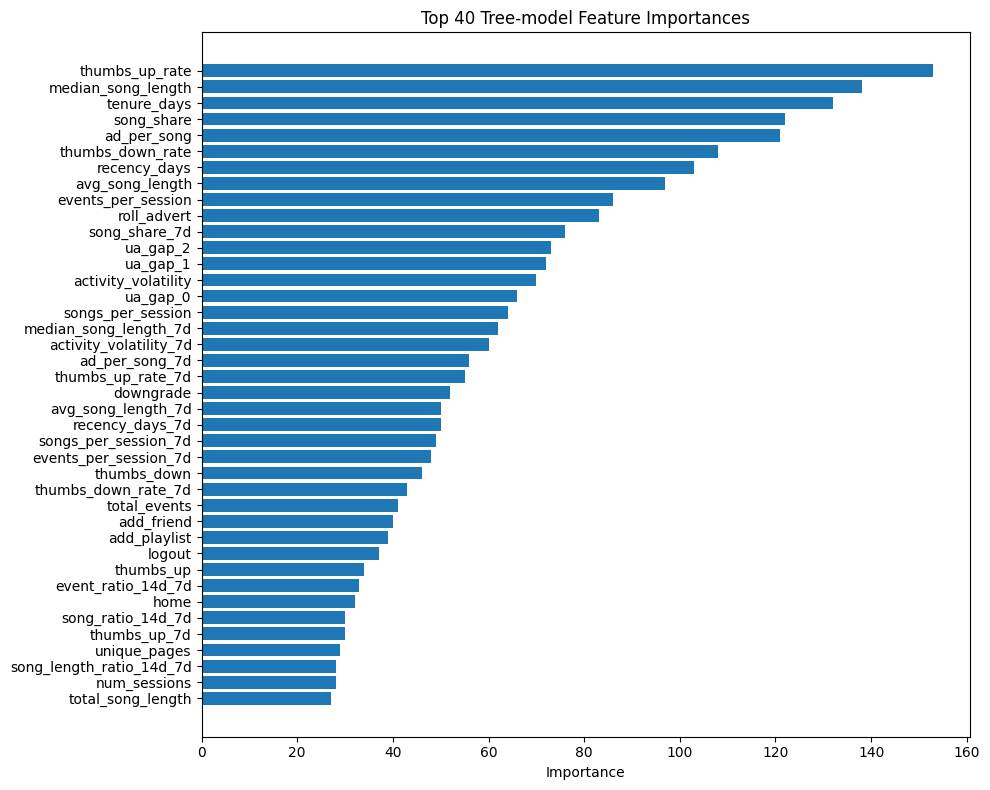

,feature,importance
29,thumbs_up_rate,153
26,median_song_length,138
33,tenure_days,132
27,song_share,122
28,ad_per_song,121
30,thumbs_down_rate,108
34,recency_days,103
25,avg_song_length,97
22,events_per_session,86
2,roll_advert,83


In [33]:
plot_model_importance(best_model, X_train, top_n=40)


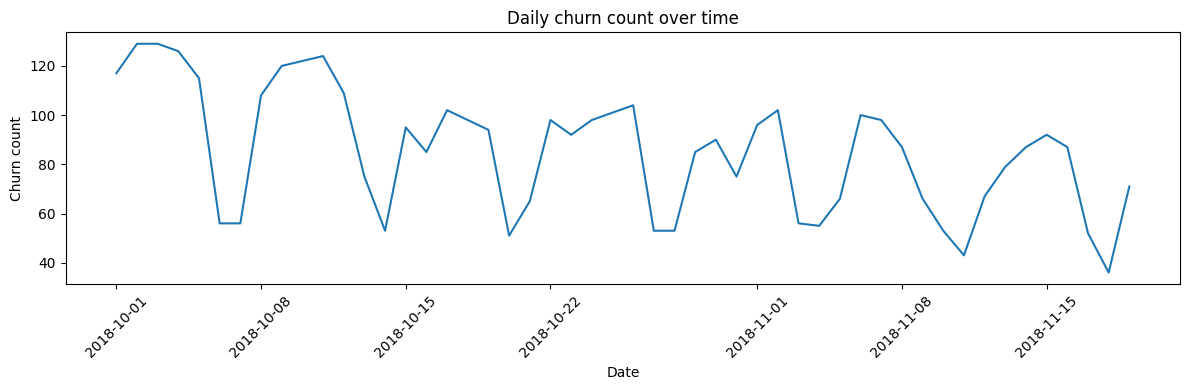

In [34]:
import matplotlib.pyplot as plt

# 1) churn 이벤트만 뽑기
churn_events = train[train['page'] == 'Cancellation Confirmation'].copy()

# 2) 날짜 단위로 보고 싶으면 (일자별)
churn_events['date'] = churn_events['time'].dt.floor('D')
daily_churn = (
    churn_events.groupby('date')
    .size()
    .reset_index(name='churn_count')
)

plt.figure(figsize=(12, 4))
plt.plot(daily_churn['date'], daily_churn['churn_count'])
plt.xlabel('Date')
plt.ylabel('Churn count')
plt.title('Daily churn count over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 만약 시간 단위(시간까지)로 보고 싶으면:
# churn_events['hour'] = churn_events['time'].dt.floor('H')
# hourly_churn = churn_events.groupby('hour').size().reset_index(name='churn_count')
# ... 같은 방식으로 plot


In [35]:
daily_churn

,date,churn_count
0,2018-10-01,117
1,2018-10-02,129
2,2018-10-03,129
3,2018-10-04,126
4,2018-10-05,115
5,2018-10-06,56
6,2018-10-07,56
7,2018-10-08,108
8,2018-10-09,120
9,2018-10-10,122


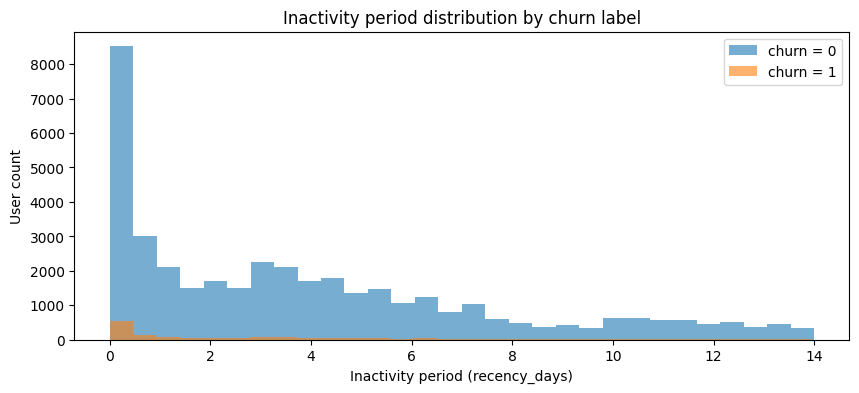

In [36]:
import matplotlib.pyplot as plt

# train dataframe 기준
df_plot = user_data_train[['recency_days', 'churned']].dropna()

plt.figure(figsize=(10, 4))

# churn = 0
plt.hist(
    df_plot[df_plot['churned'] == 0]['recency_days'],
    bins=30,
    alpha=0.6,
    label='churn = 0'
)

# churn = 1
plt.hist(
    df_plot[df_plot['churned'] == 1]['recency_days'],
    bins=30,
    alpha=0.6,
    label='churn = 1'
)

plt.xlabel('Inactivity period (recency_days)')
plt.ylabel('User count')
plt.title('Inactivity period distribution by churn label')
plt.legend()
plt.show()


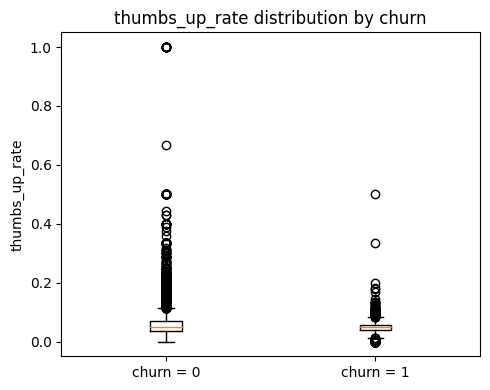

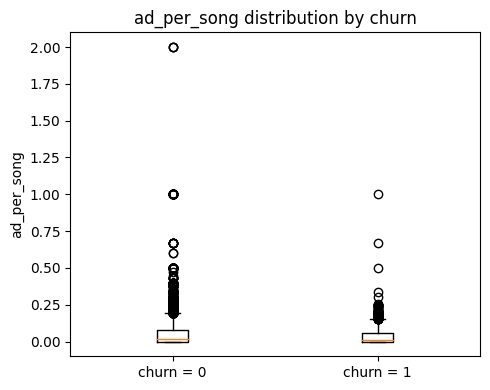

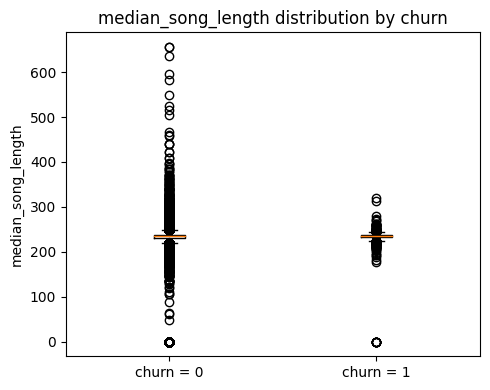

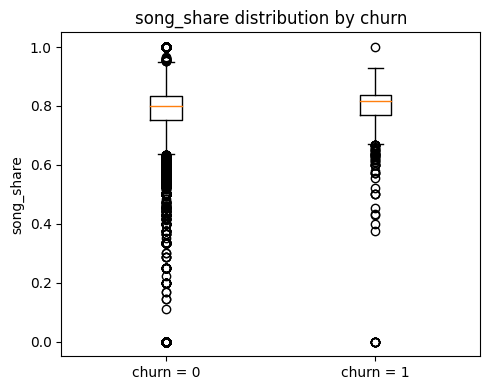

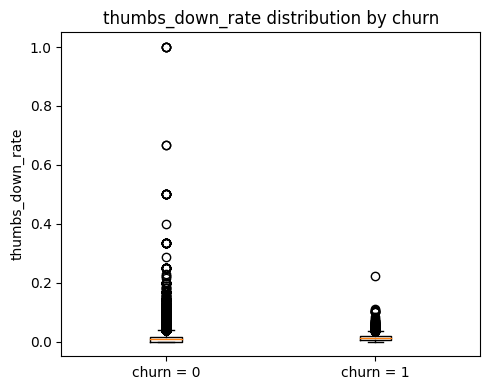

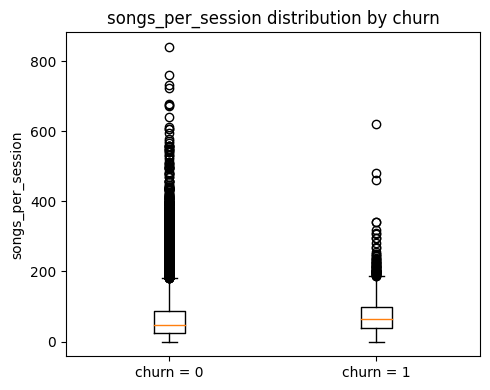

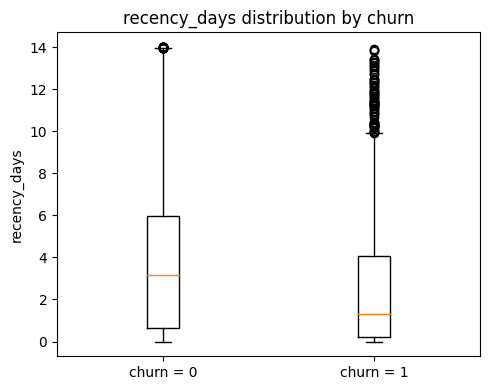

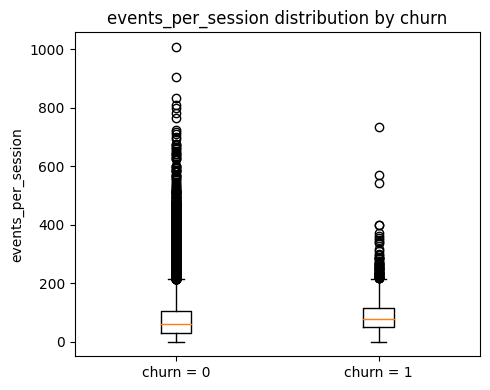

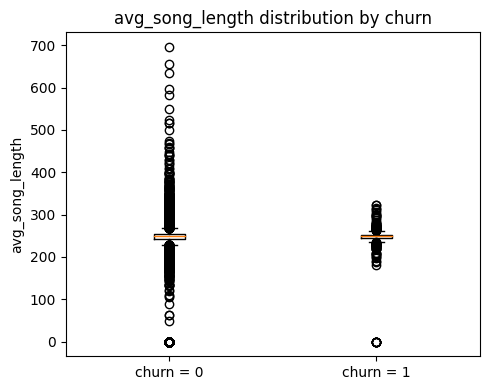

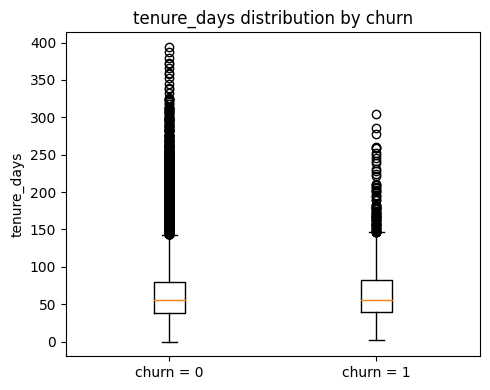

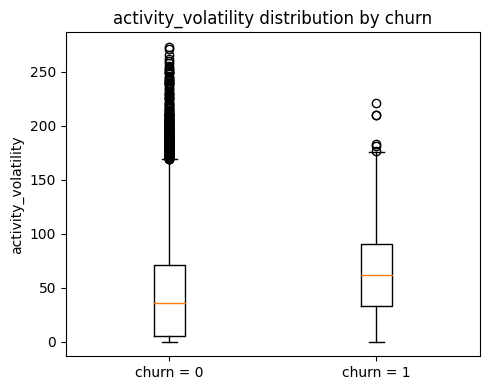

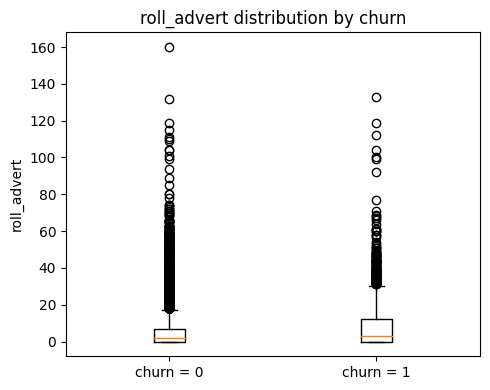

In [37]:
features_to_check = [
    'thumbs_up_rate',
    'ad_per_song',
    'median_song_length',
    'song_share',
    'thumbs_down_rate',
    'songs_per_session',
    'recency_days',
    'events_per_session',
    'avg_song_length',
    'tenure_days',
    'activity_volatility',
    'roll_advert'
]

import matplotlib.pyplot as plt

for col in features_to_check:
    if col not in user_data_train.columns:
        continue

    data_0 = user_data_train[user_data_train['churned'] == 0][col]
    data_1 = user_data_train[user_data_train['churned'] == 1][col]

    plt.figure(figsize=(5, 4))
    plt.boxplot(
        [data_0.dropna(), data_1.dropna()],
        labels=['churn = 0', 'churn = 1'],
        showfliers=True
    )
    plt.title(f'{col} distribution by churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



In [38]:
import pandas as pd

outlier_summary = []

for col in features_to_check:
    if col not in user_data_train.columns:
        continue

    series = user_data_train[col].dropna()
    if series.empty:
        continue

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n_outliers = ((series < lower) | (series > upper)).sum()

    outlier_summary.append({
        'feature': col,
        'n_outliers': n_outliers,
        'outlier_ratio': n_outliers / len(series)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(
    'outlier_ratio', ascending=False
)

outlier_df


,feature,n_outliers,outlier_ratio
2,median_song_length,4296,0.103803
8,avg_song_length,4013,0.096965
11,roll_advert,3062,0.073986
4,thumbs_down_rate,2084,0.050355
9,tenure_days,1901,0.045933
0,thumbs_up_rate,1900,0.045909
3,song_share,1858,0.044894
7,events_per_session,1826,0.044121
5,songs_per_session,1812,0.043783
1,ad_per_song,994,0.024018
